# Imports

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from pystoi import stoi # entre 0 et 1. Plus c'est proche de 1, mieux c'est
import scipy
import torchmetrics
from torch.utils.data import DataLoader
from torchmetrics.audio.pesq import PerceptualEvaluationSpeechQuality
import torch
from dummy import Dummy
import torch.nn as nn
import torch.nn.functional as F
import IPython.display as ipd
from scipy.signal import stft, istft
#from dummy_model import Dummy_model
import tqdm
import pandas as pd

c:\Users\grego\miniconda3\envs\map588\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SAMPLERATE = 8000

In [3]:
train_files_clean = os.listdir('./data/Audio/voice_origin/train/train/')
train_files_noise = os.listdir('./data/Audio/denoising/train/train/')
test_files_clean = os.listdir('./data/Audio/voice_origin/test/test/')
test_files_noise = os.listdir('./data/Audio/denoising/test/test/')

In [4]:
print('Il y a', len(train_files_clean), 'fichiers d\'entrainement propres')
print('Il y a', len(train_files_noise), 'fichiers d\'entrainement bruités')
print('Il y a', len(test_files_clean), 'fichiers de test propres')
print('Il y a', len(test_files_noise), 'fichiers de test bruités')

Il y a 2118 fichiers d'entrainement propres
Il y a 2118 fichiers d'entrainement bruités
Il y a 782 fichiers de test propres
Il y a 782 fichiers de test bruités


Visualisation d'un signal

In [5]:
index=9
file_clean='./data/Audio/voice_origin/train/train/' + train_files_clean[index]
file_noise='./data/Audio/denoising/train/train/' + train_files_noise[index]
samplerate_clean, data_clean = wavfile.read(file_clean) # sample rate is the sample frequency of the audio
samplerate_noise, data_noise = wavfile.read(file_noise)

In [6]:
print('Data Propre')
ipd.Audio(data=data_clean, rate=samplerate_clean)

Data Propre


In [7]:
print('Data Buitée')
ipd.Audio(data=data_noise, rate=samplerate_noise)

Data Buitée


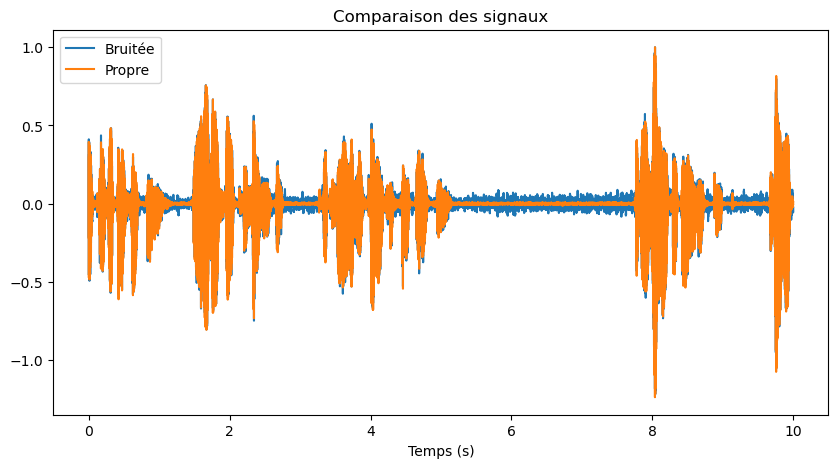

In [8]:
data_clean = data_clean/np.max(data_clean)
data_noise = data_noise/np.max(data_noise)

temps = np.arange(len(data_clean))/SAMPLERATE
plt.figure(figsize=(10,5))
plt.plot(temps, data_noise, label = 'Bruitée')
plt.plot(temps, data_clean, label = 'Propre')
plt.xlabel('Temps (s)')
plt.title('Comparaison des signaux')
plt.legend()

# U-Net

## Data Preprocessing

On commence par transformer les données en stft et les stocker dans data. On stocke le stft normalisé (toutes les valeurs sont entre 0 et 1).

In [9]:
convert_files = False
# set to True to convert the files to spectrogrammes
if convert_files: 
    np.random.seed(0)
    for i in tqdm.tqdm(range(len(test_files_noise))):
        file = test_files_noise[i]
        samplerate, data = wavfile.read('./data/Audio/denoising/test/test/' + file)
        frequencies, times, Zxx = stft(data, fs=samplerate, nperseg=500)
        pd.DataFrame(data=Zxx).to_csv('./data/spectrogrammes/test/noisy/' + file + '.csv')

    for i in tqdm.tqdm(range(len(test_files_clean))):
        file = test_files_noise[i]
        samplerate, data = wavfile.read('./data/Audio/voice_origin/test/test/' + file)
        frequencies, times, Zxx = stft(data, fs=samplerate, nperseg=500)
        pd.DataFrame(data=Zxx).to_csv('./data/spectrogrammes/test/origin/' + file + '.csv')
        
    for i in tqdm.tqdm(range(len(train_files_noise))):
        file = train_files_noise[i]
        samplerate, data = wavfile.read('./data/Audio/denoising/train/train/' + file)
        samplerate_clean, data_clean=wavfile.read('./data/Audio/voice_origin/train/train/' + file)
        frequencies, times, Zxx = stft(data, fs=samplerate, nperseg=500)
        frequencies_clean, times_clean, Zxx_clean = stft(data_clean, fs=samplerate_clean, nperseg=500)
        if np.random.random() > 0.8 :
            pd.DataFrame(data=Zxx).to_csv('./data/spectrogrammes/validation/noisy/' + file + '.csv')
            pd.DataFrame(data=Zxx_clean).to_csv('./data/spectrogrammes/validation/origin/' + file + '.csv')
        else : 
            pd.DataFrame(data=Zxx).to_csv('./data/spectrogrammes/train/noisy/' + file + '.csv')
            pd.DataFrame(data=Zxx_clean).to_csv('./data/spectrogrammes/train/origin/' + file + '.csv')

Conversion en fichiers .npy

In [10]:
# conversion en npy : 
convert_files = False
  
if convert_files: 
    np.random.seed(0)
    for i in tqdm.tqdm(range(len(test_files_noise))):
        file = test_files_noise[i]
        samplerate, data = wavfile.read('./data/Audio/denoising/test/test/' + file)
        frequencies, times, Zxx = stft(data, fs=samplerate, nperseg=500)
        np.save('./data/spectrogrammes/test/noisy/' + file + '.npy', Zxx)

    for i in tqdm.tqdm(range(len(test_files_clean))):
        file = test_files_noise[i]
        samplerate, data = wavfile.read('./data/Audio/voice_origin/test/test/' + file)
        frequencies, times, Zxx = stft(data, fs=samplerate, nperseg=500)
        np.save('./data/spectrogrammes/test/origin/' + file + '.npy', Zxx)
        
    for i in tqdm.tqdm(range(len(train_files_noise))):
        file = train_files_noise[i]
        samplerate, data = wavfile.read('./data/Audio/denoising/train/train/' + file)
        samplerate_clean, data_clean=wavfile.read('./data/Audio/voice_origin/train/train/' + file)
        frequencies, times, Zxx = stft(data, fs=samplerate, nperseg=500)
        frequencies_clean, times_clean, Zxx_clean = stft(data_clean, fs=samplerate_clean, nperseg=500)
        if np.random.random() > 0.8 :
            np.save('./data/spectrogrammes/validation/noisy/' + file + '.npy', Zxx)
            np.save('./data/spectrogrammes/validation/origin/' + file + '.npy', Zxx_clean)
        else : 
            np.save('./data/spectrogrammes/train/noisy/' + file + '.npy', Zxx)
            np.save('./data/spectrogrammes/train/origin/' + file + '.npy', Zxx_clean)

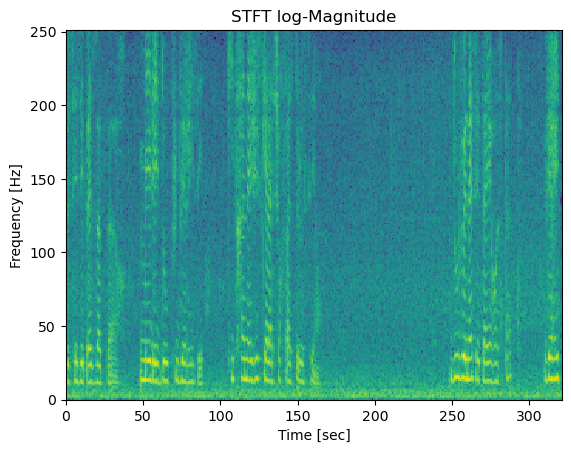

In [11]:
# visualisation d'un spectrogramme
try : 
    file = train_files_noise[index]
    Zxx = np.load('./data/spectrogrammes/train/noisy/' + file + '.npy')
    plt.pcolormesh(np.log(np.abs(Zxx)))
    plt.title('STFT log-Magnitude')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.savefig('spectrogramme.png')
    plt.show()
except :
    from PIL import Image
    img = Image.open('spectrogramme.png')
    display(img)

In [12]:
class Mydataset(torch.utils.data.Dataset):
    def __init__(self, path_to_data):
        self.path_to_data = path_to_data
        self.X = [elt for elt in os.listdir(path_to_data + 'noisy/') if 'npy' in elt]
        self.Y = [elt for elt in os.listdir(path_to_data + 'origin/') if 'npy' in elt]


    def __len__(self):
        assert len(self.X) == len(self.Y)
        return len(self.X)

    def __getitem__(self, idx):
        noised=np.load(self.path_to_data + 'noisy/' + self.X[idx], allow_pickle=True)
        noised_real=noised.real
        noised_imag=noised.imag
        origin=np.load(self.path_to_data + 'origin/' + self.Y[idx],  allow_pickle=True)
        origin_real=origin.real
        origin_imag=origin.imag
        return torch.tensor([noised_real, noised_imag]), torch.tensor([origin_real, origin_imag]) # 1, 129, 357 chacuns 

Création de datasets d'entrainement, de validation et de test.

In [13]:
dataloader_test = DataLoader(Mydataset('./data/spectrogrammes/test/'), batch_size=10 , shuffle=True)
dataloader_train = DataLoader(Mydataset('./data/spectrogrammes/train/'), batch_size=10 , shuffle=True)
dataloader_validation = DataLoader(Mydataset('./data/spectrogrammes/validation/'), batch_size=10 , shuffle=True)
for batch in dataloader_test :
  print(batch[0].shape, batch[1].shape)
  break
print("il y a deux canaux au début, un pour la partie réelle et un pour la partie imaginaire")

C:\Users\grego\AppData\Local\Temp\ipykernel_29436\1791884614.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:264.)
  return torch.tensor([noised_real, noised_imag]), torch.tensor([origin_real, origin_imag]) # 1, 129, 357 chacuns


torch.Size([10, 2, 251, 321]) torch.Size([10, 2, 251, 321])
il y a deux canaux au début, un pour la partie réelle et un pour la partie imaginaire


## Models

Dummy model as baseline

In [14]:
class Dummy_model(nn.Module): 
    def __init__(self): 
        super(Dummy_model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=1,  kernel_size=11, stride=1, padding='same')
    def forward(self, x): # [10, 2, 251, 321]
        x = self.conv1(x)
        x = F.relu(x) # [10, 1, 251, 321]
        return x

In [15]:
class Small_Unet (nn.Module):

  def __init__(self):
    super(Small_Unet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=2, out_channels=16, kernel_size=(11, 11), stride=2, padding=5)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(8, 8), stride=2, padding=4)
    self.deconv1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(8, 8), stride=2, padding=4, output_padding=1)
    # drop a dimension in the output to go from [10, 16, 127, 161] to [10, 16, 126, 161] 
    self.deconv2 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=(11, 11), stride=2, padding=5)
    

  def forward(self, x): # x = [10, 2, 251, 321]
    x = F.relu(self.conv1(x)) # [10, 16, 126, 161]
    x = F.relu(self.conv2(x)) # [10, 32, 64, 81]
    x = F.relu(self.deconv1(x)) #[10, 16, 127, 161]
    x = x[:, :, :126, :] # slicing nécessaire pour que les dimensions correspondent, car la convolution transpose n'est pas l'inverse de la convolution x.shape -> #[10, 16, 127, 161]
    x = F.relu(self.deconv2(x)) #[10, 1, 251, 321]
    return x # on ressort un masque

In [16]:
class UNet(nn.Module): 
    def __init__(self):
        super(UNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=32, kernel_size=(5, 5), stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5, 5), stride=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(5, 5), stride=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(5, 5), stride=2)
        self.deconv1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=(6, 6), stride=2)
        self.deconv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(6, 6), stride=2)
        self.deconv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(6, 6), stride=2)
        self.deconv4 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(6, 6), stride=2)
        self.deconv5 = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=(5, 5), stride=2)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.bn_deconv1 = nn.BatchNorm2d(256)
        self.bn_deconv2 = nn.BatchNorm2d(128)
        self.bn_deconv3 = nn.BatchNorm2d(64)
        self.bn_deconv4 = nn.BatchNorm2d(32)

    def forward(self, x): 
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x, negative_slope=0.2)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.leaky_relu(x, negative_slope=0.2)

        x = self.conv4(x)
        x = F.dropout(x, p=0.5)
        x = self.bn4(x)

        x = self.conv5(x)
        x = F.dropout(x, p=0.5)
        x = self.bn5(x)

        x = self.deconv1(x)
        x = x[:, :, :, :17]
        x = self.bn_deconv1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5)

        x = self.deconv2(x)
        x = x[:, :, :, :37]
        x = self.bn_deconv2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5)

        x = self.deconv3(x)
        x = self.bn_deconv3(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5)

        x = self.deconv4(x)
        x = self.bn_deconv4(x)
        x = F.relu(x)

        x = self.deconv5(x)
        x = x[:, :, :, :321]
        x = torch.sigmoid(x)
        return x

In [17]:
# number of parameters
model = UNet()
print('Nombre de paramètres de UNet :', sum(p.numel() for p in model.parameters() if p.requires_grad))
model = Small_Unet()
print('Nombre de paramètres de Small_Unet :', sum(p.numel() for p in model.parameters() if p.requires_grad))
model=Dummy_model()
print('Nombre de paramètres de Dummy_model :', sum(p.numel() for p in model.parameters() if p.requires_grad))

Nombre de paramètres de UNet : 10625697
Nombre de paramètres de Small_Unet : 71409
Nombre de paramètres de Dummy_model : 243


In [18]:
def compute_receptive_field(model, input_shape):
    x = torch.zeros(*input_shape)
    x.requires_grad_(True)
    output = model(x)
    # Choisir un pixel au centre de la sortie
    central_pixel = output[..., output.shape[-2] // 2, output.shape[-1] // 2]
    central_pixel.backward()
    grad = x.grad
    field = (grad != 0).nonzero()
    min_coords = field.min(dim=0)[0]
    max_coords = field.max(dim=0)[0]
    return max_coords - min_coords + 1

In [19]:
print(f"Le champ réceptif du Unet est tensor([  1,   2, 251, 321])")

Le champ réceptif du Unet est tensor([  1,   2, 251, 321])


In [20]:
print(f"Le champ réceptif du small unet est tensor([ 1,  2, 45, 45])")
print('environ 1.5 sec')

Le champ réceptif du small unet est tensor([ 1,  2, 45, 45])
environ 1.5 sec


In [21]:
print(f"Le champ réceptif du dummy est tensor([ 1,  2, 21, 21])")
print('environ 0.7 sec')

Le champ réceptif du dummy est tensor([ 1,  2, 21, 21])
environ 0.7 sec


In [22]:
chemin_vers_sauvegarde_dummy = './models/dummy_model/'

In [23]:
# set train_dummy to True to train the model
train_dummy_model = False

model_name='dummy_model'
if not os.path.exists('./models/'+model_name):
    os.makedirs('./models/'+model_name)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = Dummy_model()
n_epochs=200
loss = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters())
model.to(device)
loss_train=[]
loss_val=[]
if train_dummy_model:
    for epoch in (range(n_epochs)):
        print(epoch)
        losstrain=0
        counttrain=0
        lossval=0
        countval=0
        for batch_x,batch_y in dataloader_train:
            counttrain+=1
            batch_x=batch_x.to(device)
            batch_y = batch_y.long()
            batch_y=batch_y.to(device)
            optimizer.zero_grad()
            mask_predicted = model(batch_x.float())
            batch_y_predicted = batch_x * mask_predicted
            l = loss(batch_y_predicted, batch_y)
            l.backward()
            losstrain+=l
            optimizer.step()
        for batch_x,batch_y in dataloader_validation:
            countval+=1
            batch_x=batch_x.to(device)
            batch_y = batch_y.to(device)
            with torch.no_grad():
                mask_predicted = model(batch_x.float())
                batch_y_predicted =  batch_x * mask_predicted
                l = loss(batch_y_predicted, batch_y)
                lossval+=l
        if epoch%10==0:
            print(f'epoch {epoch}, training loss = {losstrain/counttrain}')
        loss_train.append(losstrain/counttrain)
        loss_val.append(lossval/countval)
        
    torch.save(model, chemin_vers_sauvegarde_dummy+'_final'+'.pth')


    # saving the losses in txt files : 
    loss_list_val = [loss_val[i].detach().cpu().numpy() for i in range(len(loss_val))]
    loss_list_train = [loss_train[i].detach().cpu().numpy() for i in range(len(loss_train))]


    with open('./losses/loss_val_'+model_name+'.txt', 'w') as f : 
        for elt in loss_list_val : 
            f.write(str(elt) + '\n')

    with open('./losses/loss_train_'+model_name+'.txt', 'w') as f :
        for elt in loss_list_train : 
            f.write(str(elt) + '\n')

In [24]:
dummy_model_loaded =  torch.load('models/dummy_model/dummy_model_0.pth',map_location=torch.device('cpu'))

In [25]:
chemin_vers_sauvegarde_model ='./models/dummy_snd_test/_final.pth'

In [26]:
# set train_dummy to True to train the model
train_small_unet = False

model_name='dummy_snd_test'
if not os.path.exists('./models/'+model_name):
    os.makedirs('./models/'+model_name)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = Small_Unet()
n_epochs=200
loss = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters())
model.to(device)
loss_train=[]
loss_val=[]
if train_small_unet:
    for epoch in (range(n_epochs)):
        print(epoch)
        losstrain=0
        counttrain=0
        lossval=0
        countval=0
        for batch_x,batch_y in dataloader_train:
            counttrain+=1
            batch_x=batch_x.to(device)
            batch_y = batch_y.long()
            batch_y=batch_y.to(device)
            optimizer.zero_grad()
            mask_predicted = model(batch_x.float())
            batch_y_predicted = batch_x * mask_predicted
            l = loss(batch_y_predicted, batch_y)
            l.backward()
            losstrain+=l
            optimizer.step()
        for batch_x,batch_y in dataloader_validation:
            countval+=1
            batch_x=batch_x.to(device)
            batch_y = batch_y.to(device)
            with torch.no_grad():
                mask_predicted = model(batch_x.float())
                batch_y_predicted =  batch_x * mask_predicted
                l = loss(batch_y_predicted, batch_y)
                lossval+=l
        if epoch%10==0:
            print(f'epoch {epoch}, training loss = {losstrain/counttrain}')
            torch.save(model, chemin_vers_sauvegarde_model+model_name+'_'+str(epoch)+'.pth')
        loss_train.append(losstrain/counttrain)
        loss_val.append(lossval/countval)
        
    torch.save(model, chemin_vers_sauvegarde_model+'_final'+'.pth')


    # saving the losses in txt files : 
    loss_list_val = [loss_val[i].detach().cpu().numpy() for i in range(len(loss_val))]
    loss_list_train = [loss_train[i].detach().cpu().numpy() for i in range(len(loss_train))]


    with open('./losses/loss_val_'+model_name+'.txt', 'w') as f : 
        for elt in loss_list_val : 
            f.write(str(elt) + '\n')

    with open('./losses/loss_train_'+model_name+'.txt', 'w') as f :
        for elt in loss_list_train : 
            f.write(str(elt) + '\n')

In [27]:
small_unet_loaded =  torch.load(chemin_vers_sauvegarde_model,map_location=torch.device('cpu'))

In [28]:
chemin_vers_sauvegarde_unet ='./models/unet/unet'

In [29]:
# set train_unet to True to train the model
train_unet = False
model_name='unet'
if not os.path.exists('./models/'+model_name):
    os.makedirs('./models/'+model_name)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = UNet()
n_epochs=500
loss = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters())
model.to(device)
loss_train=[]
loss_val=[]
if train_unet:
    for epoch in (range(n_epochs)):
        print(epoch)
        losstrain=0
        counttrain=0
        lossval=0
        countval=0
        for batch_x,batch_y in dataloader_train:
            counttrain+=1
            batch_x=batch_x.to(device)
            batch_y = batch_y.long()
            batch_y=batch_y.to(device)
            optimizer.zero_grad()
            mask_predicted = model(batch_x.float())
            batch_y_predicted = batch_x * mask_predicted
            l = loss(batch_y_predicted, batch_y)
            l.backward()
            losstrain+=l
            optimizer.step()
        for batch_x,batch_y in dataloader_validation:
            countval+=1
            batch_x=batch_x.to(device)
            batch_y = batch_y.to(device)
            with torch.no_grad():
                mask_predicted = model(batch_x.float())
                batch_y_predicted =  batch_x * mask_predicted
                l = loss(batch_y_predicted, batch_y)
                lossval+=l
        if epoch%10==0:
            print(f'epoch {epoch}, training loss = {losstrain/counttrain}')
            torch.save(model, chemin_vers_sauvegarde_unet+'_'+str(epoch)+'.pth')
        loss_train.append(losstrain/counttrain)
        loss_val.append(lossval/countval)
        
    torch.save(model, chemin_vers_sauvegarde_unet+'_final'+'.pth')


    # saving the losses in txt files : 
    loss_list_val = [loss_val[i].detach().cpu().numpy() for i in range(len(loss_val))]
    loss_list_train = [loss_train[i].detach().cpu().numpy() for i in range(len(loss_train))]


    with open('./losses/loss_val_'+model_name+'.txt', 'w') as f : 
        for elt in loss_list_val : 
            f.write(str(elt) + '\n')

    with open('./losses/loss_train_'+model_name+'.txt', 'w') as f :
        for elt in loss_list_train : 
            f.write(str(elt) + '\n')

In [30]:
unet_loaded = torch.load(chemin_vers_sauvegarde_unet+'_final.pth',map_location=torch.device('cpu'))

In [31]:
idiot_loaded = torch.load('models/model_idiot/model_idiot_170.pth', map_location=torch.device('cpu'))

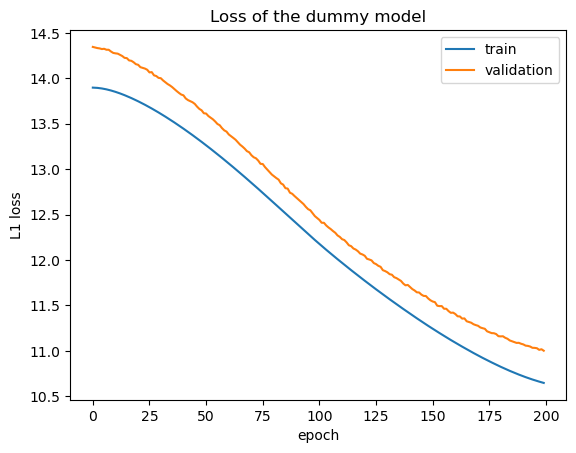

In [32]:
with open('./losses/loss_train_dummy_model.txt', 'r') as f : 
    loss_train = [float(elt) for elt in f.readlines()]

with open('./losses/loss_val_dummy_model.txt', 'r') as f :
    loss_val = [float(elt) for elt in f.readlines()]
plt.plot(loss_train, label='train')
plt.plot(loss_val, label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('L1 loss')
plt.title('Loss of the dummy model')
plt.show()

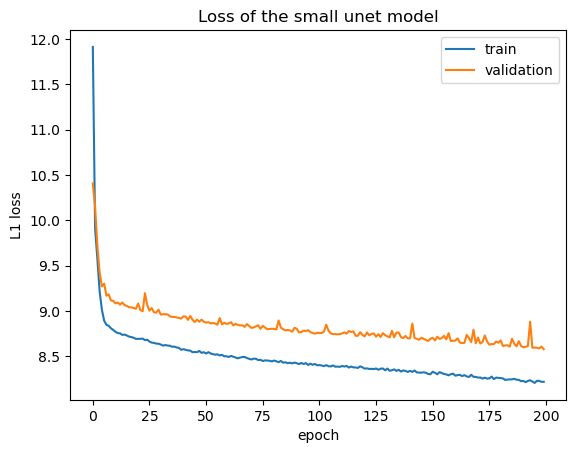

In [33]:
with open('./losses/loss_train_dummy_snd_test.txt', 'r') as f : 
    loss_train = [float(elt) for elt in f.readlines()]

with open('./losses/loss_val_dummy_snd_test.txt', 'r') as f :
    loss_val = [float(elt) for elt in f.readlines()]
plt.plot(loss_train, label='train')
plt.plot(loss_val, label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('L1 loss')
plt.title('Loss of the small unet model')
plt.show()

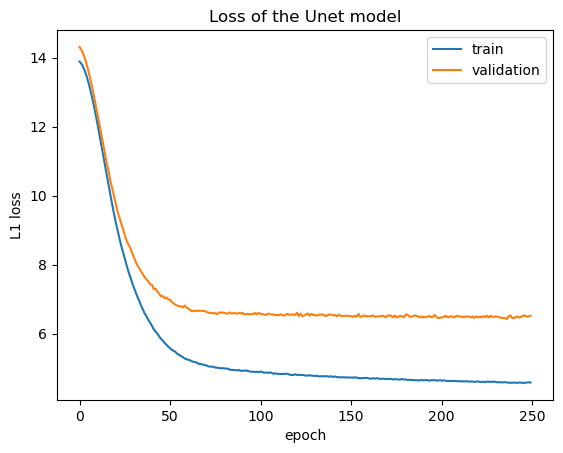

In [34]:
with open('./losses/loss_train_unet.txt', 'r') as f : 
    loss_train = [float(elt) for elt in f.readlines()]

with open('./losses/loss_val_unet.txt', 'r') as f :
    loss_val = [float(elt) for elt in f.readlines()]
plt.plot(loss_train, label='train')
plt.plot(loss_val, label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('L1 loss')
plt.title('Loss of the Unet model')
plt.show()

### Evaluation

test avec un fichier:

In [35]:
index_to_test = 68

In [36]:
unet_test = unet_loaded
small_unet_test = small_unet_loaded
dummy_test = idiot_loaded

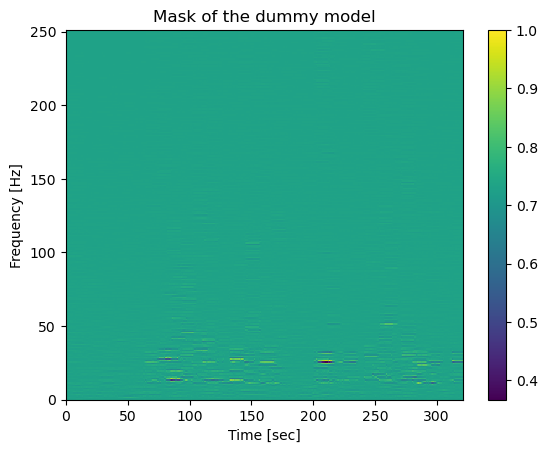

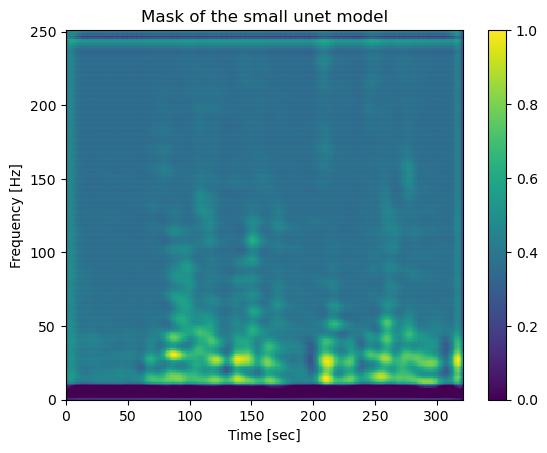

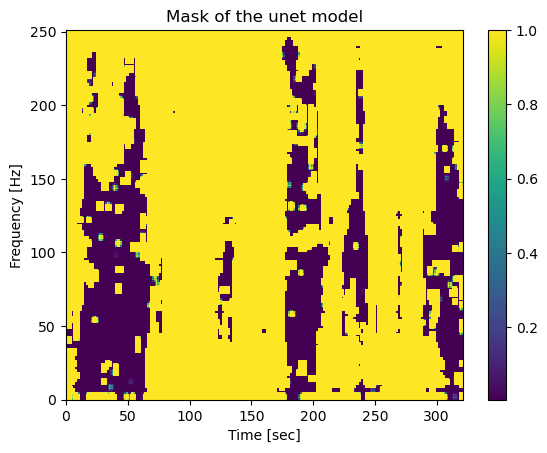

In [37]:
try : 
    samplerate, data = wavfile.read('data/Audio/denoising/test/test/'+ test_files_noise[index_to_test]) 
    _, _, Zxx = stft(data, fs=samplerate, nperseg=500)
    x=torch.tensor([[Zxx.real, Zxx.imag]])
    mask = dummy_test(x)
    mask = mask.detach().numpy()
    mask = np.abs(mask[0, 0])
    mask = mask / np.max(mask)
    # plot mask 
    plt.pcolormesh(mask)
    plt.title('Mask of the dummy model')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    # show colorbar
    plt.colorbar()
    plt.savefig('mask_dummy.png')
    plt.show()

    mask = small_unet_test(x)
    mask = mask.detach().numpy()
    mask = np.abs(mask[0, 0])
    mask = mask / np.max(mask)
    # plot mask 
    plt.pcolormesh(mask)
    plt.title('Mask of the small unet model')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    # show colorbar
    plt.colorbar()
    plt.savefig('mask_small_unet.png')
    plt.show()


    mask = unet_test(x)
    mask = mask.detach().numpy()
    mask = np.abs(mask[0, 0])
    mask = mask / np.max(mask)
    # plot mask 
    plt.pcolormesh(mask)
    plt.title('Mask of the unet model')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    # show colorbar
    plt.colorbar()
    plt.savefig('mask_unet.png')
    plt.show()
except :
    from PIL import Image
    img = Image.open('mask_dummy.png')
    display(img)
    img = Image.open('mask_small_unet.png')
    display(img)
    img = Image.open('mask_unet.png')
    display(img)

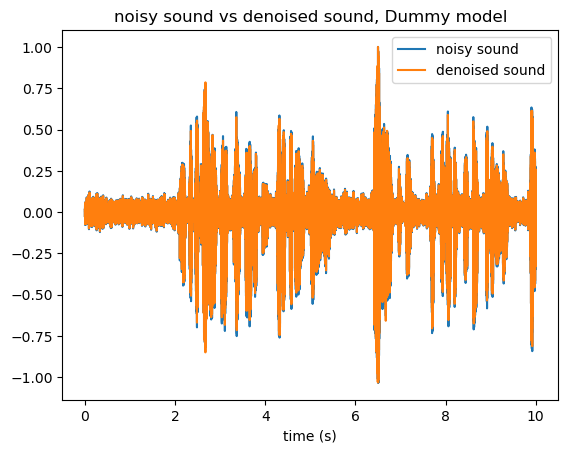

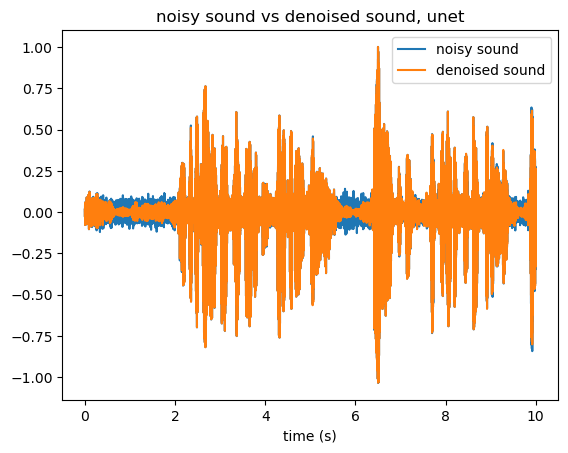

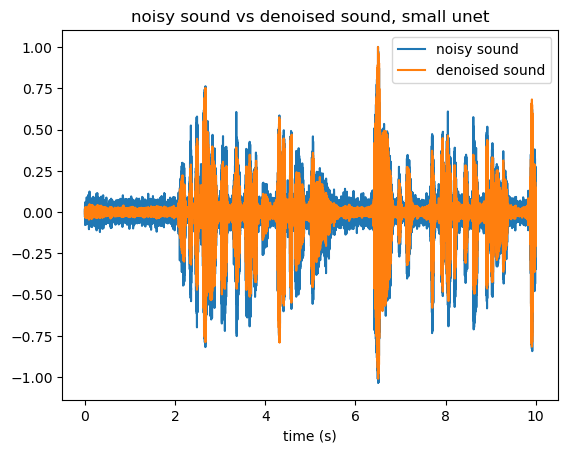

In [38]:
try : 
    samplerate, y_noisy = wavfile.read('data/Audio/denoising/test/test/'+ test_files_noise[index_to_test]) 
    _, y_clean = wavfile.read('data/Audio/voice_origin/test/test/'+ test_files_noise[index_to_test]) 
    # save both sounds 
    wavfile.write('data_test/noisy.wav', samplerate, y_noisy)
    wavfile.write('data_test/clean.wav', samplerate, y_clean)
except : 
    y_noisy = wavfile.read('data_test/noisy.wav')[1]
    y_clean = wavfile.read('data_test/clean.wav')[1]
    samplerate = 8000
def denoise(model, samplerate, data): # denoising an audio
    # le modele doit renvoyer un masque. 
    _, _, Zxx = stft(data, fs=samplerate, nperseg=500)
    assert Zxx.shape == (251, 321)
    x=torch.tensor([[Zxx.real, Zxx.imag]])
    mask = model(x)
    y_predicted = Zxx * mask.detach().numpy()
    _, y = istft(y_predicted, fs=samplerate)
    return y[0][0] / np.max(y[0][0])

y_denoised_dummy_model = denoise(dummy_test, samplerate, y_noisy)
plt.plot([i/ samplerate for i in range(len(y_noisy))],   y_noisy/np.max(y_noisy), label='noisy sound')
plt.plot([i/ samplerate for i in range(len(y_noisy))], y_denoised_dummy_model, label = 'denoised sound')
plt.legend()
plt.xlabel('time (s)')
plt.title('noisy sound vs denoised sound, Dummy model')
plt.show()
y_denoised_unet = denoise(unet_test, samplerate, y_noisy)
plt.plot([i/ samplerate for i in range(len(y_noisy))],   y_noisy/np.max(y_noisy), label='noisy sound')
plt.plot([i/ samplerate for i in range(len(y_noisy))], y_denoised_unet, label = 'denoised sound')
plt.legend()
plt.xlabel('time (s)')
plt.title('noisy sound vs denoised sound, unet')
plt.show()
y_denoised_small_unet = denoise(small_unet_loaded, samplerate, y_noisy)
plt.plot([i/ samplerate for i in range(len(y_noisy))],   y_noisy/np.max(y_noisy), label='noisy sound')
plt.plot([i/ samplerate for i in range(len(y_noisy))], y_denoised_small_unet, label = 'denoised sound')
plt.legend()
plt.xlabel('time (s)')
plt.title('noisy sound vs denoised sound, small unet')
plt.show()

son original:

In [39]:
ipd.Audio(y_clean, rate=SAMPLERATE)

son bruité:

In [40]:
ipd.Audio(y_noisy, rate=SAMPLERATE)

son débruité par dummy :

In [41]:
ipd.Audio(y_denoised_dummy_model, rate=SAMPLERATE)

son débruité par unet

In [42]:
ipd.Audio(y_denoised_unet, rate=SAMPLERATE)

son débruité par small unet

In [43]:
ipd.Audio(y_denoised_small_unet, rate=SAMPLERATE)

In [44]:
original_stoi, new_stoi = stoi(y_noisy, y_clean, SAMPLERATE) , stoi(y_denoised_unet, y_clean, SAMPLERATE)
print(f"On passe d'un stoi de {original_stoi} à {new_stoi} en denoisant le signal avec unet")

original_stoi, new_stoi = stoi(y_noisy, y_clean, SAMPLERATE) , stoi(y_denoised_small_unet, y_clean, SAMPLERATE)
print(f"On passe d'un stoi de {original_stoi} à {new_stoi} en denoisant le signal avec small unet")

original_stoi, new_stoi = stoi(y_noisy, y_clean, SAMPLERATE) , stoi(y_denoised_dummy_model, y_clean, SAMPLERATE)
print(f"On passe d'un stoi de {original_stoi} à {new_stoi} en denoisant le signal avec dummy model")

On passe d'un stoi de 0.6256735682464195 à 0.7254766345497546 en denoisant le signal avec unet
On passe d'un stoi de 0.6256735682464195 à 0.6363598559537734 en denoisant le signal avec small unet
On passe d'un stoi de 0.6256735682464195 à 0.6253611354501777 en denoisant le signal avec dummy model


In [45]:
def compute_stoi(model, test_files_noise, test_files_clean):
    stoi_values = []
    for i in range(len(test_files_noise)):
        samplerate, data = wavfile.read('data/Audio/denoising/test/test/'+ test_files_noise[i]) 
        y = denoise(model, samplerate, data)
        _, data_clean = wavfile.read('data/Audio/voice_origin/test/test/'+ test_files_clean[i])
        stoi_values.append(stoi(data_clean, y, SAMPLERATE, extended=False))
    return np.mean(stoi_values)

In [46]:
stoi_unet = compute_stoi(unet_test, test_files_noise, test_files_clean)
stoi_small_unet = compute_stoi(small_unet_test, test_files_noise, test_files_clean)
stoi_dummy = compute_stoi(dummy_test, test_files_noise, test_files_clean)
print(f"Le stoi moyen pour le modèle dummy est de {stoi_dummy}, pour le modèle unet de {stoi_unet} et pour le modèle small unet de {stoi_small_unet}")

Le stoi moyen pour le modèle dummy est de 0.9244435009870586, pour le modèle unet de 0.9194745179859511 et pour le modèle small unet de 0.9266477516868771


Conclusion :

STFT :

Des résultats meilleurs avec un small unet
Unet overfitte probablement

Idées d'amélioration :

- Entraîner sur le spectrogramme pour avoir la puissance plutôt que des nombres complexes + normaliser les données.
- Utiliser d'autres loss pour étudier leur impact
- Faire de l'augmentation de données avec des bruits différents, des bruits gaussiens...
- Analyser les performances en fonction du SNR

# TasNet

## Data Preprocessing

On commence par transformer les données en numpy array et les stocker dans data (pour ne pas avoir à le refaire à chaque fois)



In [55]:
# conversion en npy : 
convert_files = False
  
if convert_files: 
    np.random.seed(0)
    for i in tqdm.tqdm(range(len(test_files_noise))):
        file = test_files_noise[i]
        samplerate, data = wavfile.read('./data/Audio/denoising/test/test/' + file)
        np.save('./data/signaux/test/noisy/' + file + '.npy', data)

    for i in tqdm.tqdm(range(len(test_files_clean))):
        file = test_files_noise[i]
        samplerate, data = wavfile.read('./data/Audio/voice_origin/test/test/' + file)
        np.save('./data/signaux/test/origin/' + file + '.npy', data)
        
    for i in tqdm.tqdm(range(len(train_files_noise))):
        file = train_files_noise[i]
        samplerate, data = wavfile.read('./data/Audio/denoising/train/train/' + file)
        samplerate_clean, data_clean=wavfile.read('./data/Audio/voice_origin/train/train/' + file)
        if np.random.random() > 0.8 :
            np.save('./data/signaux/validation/noisy/' + file + '.npy', data)
            np.save('./data/signaux/validation/origin/' + file + '.npy', data_clean)
        else : 
            np.save('./data/signaux/train/noisy/' + file + '.npy', data)
            np.save('./data/signaux/train/origin/' + file + '.npy', data_clean)

In [119]:
class Mydataset(torch.utils.data.Dataset):
    def __init__(self, path_to_data):
        self.path_to_data = path_to_data
        self.X = [elt for elt in os.listdir(path_to_data + 'noisy/')]
        self.Y = [elt for elt in os.listdir(path_to_data + 'origin/')]

    def __len__(self):
        assert len(self.X) == len(self.Y)
        return len(self.X)

    def __getitem__(self, idx):
        noised=np.load(self.path_to_data + 'noisy/' + self.X[idx], allow_pickle=True)
        origin=np.load(self.path_to_data + 'origin/' + self.Y[idx],  allow_pickle=True)
        return torch.tensor([noised], dtype=torch.float32), torch.tensor([origin], dtype=torch.float32) # 1, 129, 357 chacuns

In [120]:
dataloader_test = DataLoader(Mydataset('./data/signaux/test/'), batch_size=10 , shuffle=False)
dataloader_train = DataLoader(Mydataset('./data/signaux/train/'), batch_size=10 , shuffle=True)
dataloader_validation = DataLoader(Mydataset('./data/signaux/validation/'), batch_size=10 , shuffle=True)
for batch in dataloader_test :
  print(batch[0].shape, batch[1].shape)
  break

torch.Size([10, 1, 80000]) torch.Size([10, 1, 80000])


## TasNet Model

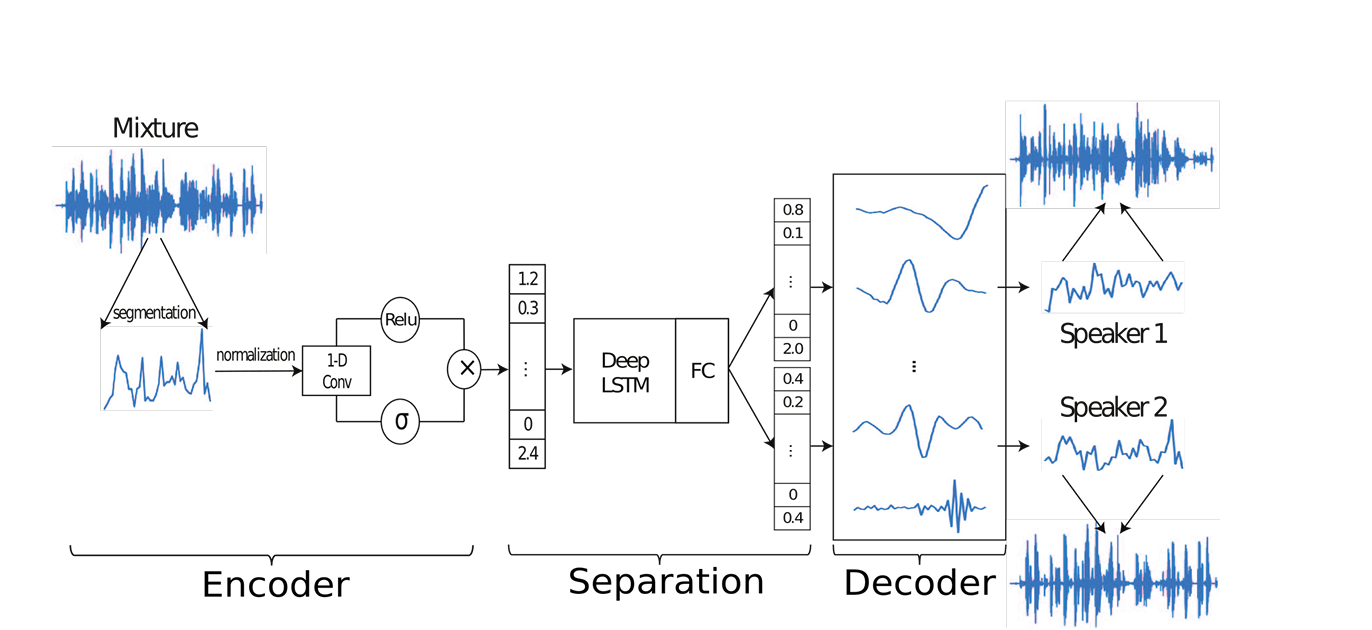

In [208]:
from PIL import Image
img = Image.open('tasnet_archi.png')
display(img)

In [121]:
class TasNetEncoder(nn.Module):
    def __init__(self, N, L):
        """
        Args:
            N (int): Number of filters (basis signals in the decoder).
            L (int): Length of each filter (segment length).
        """
        super().__init__()
        # Convolutional filters for U and V
        self.conv1d_U = nn.Conv1d(1, N, L, L, bias=False) #N = number of filters, L = length of each filter, stride = L
        self.conv1d_V = nn.Conv1d(1, N, L, L, bias=False)

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input mixture signal (batch_size, 1, time_length).
        Returns:
            torch.Tensor: Encoded mixture weights (batch_size, K, N),
                          where K is the number of segments.
        """
        # Apply gated convolutions
        U_out = F.relu(self.conv1d_U(x))  
        V_out = torch.sigmoid(self.conv1d_V(x)) 

        mixture_weights = U_out * V_out

        return mixture_weights.permute(0, 2, 1)

In [122]:
class TasNetSeparator(nn.Module):
    def __init__(self, N, H, P, num_layers, M):
        """
        Args:
            N (int): Number of filters (basis signals in the encoder).
            H (int): Number of hidden units in the LSTM layers.
            P (int): Output dimension of the fully connected layer.
            num_layers (int): Number of LSTM layers.
            M (int): Number of sources to separate (e.g., M = 1 for denoising).
        """
        super().__init__()
        self.M = M

        self.gain = nn.Parameter(torch.ones(1, N))
        self.bias = nn.Parameter(torch.zeros(1, N))

        # LSTM network
        self.lstm = nn.LSTM(N, H, num_layers, batch_first=True, bidirectional=False)

        # Fully connected layer for mask estimation
        self.fc = nn.Linear(H, N * M)  
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Encoded mixture weights (batch_size, K, N).
        Returns:
            torch.Tensor: Estimated masks (batch_size, M, K, N).
        """

        mean = x.mean(dim=2, keepdim=True) 
        std = x.std(dim=2, keepdim=True)    
        x_norm = (x - mean) / (std + 1e-8) 
        x_norm = self.gain * x_norm + self.bias  

        # LSTM forward pass
        lstm_out, _ = self.lstm(x_norm)  # (batch_size, K, H)

        # Mask estimation 
        mask_logits = self.fc(lstm_out)  
        masks = mask_logits.view(x.size(0), x.size(1), self.M, -1)  
        masks = self.softmax(masks)  

        return masks.permute(0, 2, 1, 3)  # (batch_size, M, K, N)

In [123]:
class TasNetDecoder(nn.Module):
    def __init__(self, N, L):
        """
        Args:
            N (int): Number of filters (basis signals in the encoder/decoder).
            L (int): Length of each filter (segment length).
        """
        super().__init__()
        self.N = N
        self.L = L

        self.basis_filters = nn.Parameter(torch.randn(N, L), requires_grad=True)

    def forward(self, mixture_weights, masks):
        """
        Args:
            mixture_weights (torch.Tensor): Mixture weights (batch_size, K, N).
            masks (torch.Tensor): Masks for each source (batch_size, M, K, N).

        Returns:
            torch.Tensor: Reconstructed waveforms (batch_size, M, time_length).
        """
        # Compute source weights (D_i = W ⊙ M_i)
        source_weights = masks * mixture_weights.unsqueeze(1)  # (batch_size, M, K, N)

        # Reconstruct segments for each source using the basis filters
        source_signals = torch.matmul(source_weights, self.basis_filters)  # (batch_size, M, N, L)

        # Concatenate segments along the time dimension
        batch_size, M, K, L = source_signals.shape
        time_length = K * L
        source_signals = source_signals.view(batch_size, M, time_length)  # (batch_size, M, time_length)

        return source_signals

In [124]:
class TasNet(nn.Module):
    def __init__(self, N, L, H, num_layers, M):
        """
        Args:
            N (int): Number of filters (basis signals in the encoder/decoder).
            L (int): Length of each filter (segment length).
            H (int): Number of hidden units in the LSTM layers.
            num_layers (int): Number of LSTM layers in the separator.
            M (int): Number of sources to separate (e.g., M = 1 for denoising).
        """
        super().__init__()
        self.encoder = TasNetEncoder(N=N, L=L)
        self.separator = TasNetSeparator(N=N, H=H, P=N, num_layers=num_layers, M=M)
        self.decoder = TasNetDecoder(N=N, L=L)

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input mixture waveform (batch_size, 1, time_length).
        Returns:
            torch.Tensor: Reconstructed waveforms (batch_size, M, time_length).
        """
        # Encode the input mixture waveform into mixture weights
        mixture_weights = self.encoder(x)  # Shape: (batch_size, K, N)

        # Generate masks for each source
        masks = self.separator(mixture_weights)  # Shape: (batch_size, M, K, N)

        # Reconstruct the waveforms for each source
        reconstructed_waveforms = self.decoder(mixture_weights, masks)

        return reconstructed_waveforms

## Entrainement

In [125]:
def si_snr(y_pred, y_true, eps=1e-8):
    y_true_mean = torch.mean(y_true, dim=-1, keepdim=True)
    y_pred_mean = torch.mean(y_pred, dim=-1, keepdim=True)
    
    y_true = y_true - y_true_mean
    y_pred = y_pred - y_pred_mean
    
    dot_product = torch.sum(y_pred * y_true, dim=-1, keepdim=True)
    target = dot_product * y_true / (torch.sum(y_true ** 2, dim=-1, keepdim=True) + eps)
    noise = y_pred - target
    
    si_snr_value = 10 * torch.log10(torch.sum(target ** 2, dim=-1) / (torch.sum(noise ** 2, dim=-1) + eps))
    return -torch.mean(si_snr_value)

In [126]:
def train_tasnet(model, train_loader, val_loader, si_snr_loss, num_epochs, lr, device):
    """
    Args:
        model (nn.Module): TasNet model.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        si_snr_loss (function): Loss function (SI-SNR).
        num_epochs (int): Number of epochs.
        lr (float): Learning rate for Adam optimizer.
        device (torch.device): Training device (e.g., 'cuda' or 'cpu').
    """
    # Optimizer
    optimizer = Adam(model.parameters(), lr=lr)

    #Loss mse
    criterion = nn.MSELoss()
    
    # Move model to device
    model = model.to(device)
    
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs+1):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 50)
        
        # === TRAINING ===
        model.train()
        train_loss = 0.0
        
        for noisy_signals, clean_signals in tqdm(train_loader, desc="Training", leave=False):
            noisy_signals = noisy_signals.to(device)  # (batch_size, 1, time_length)
            clean_signals = clean_signals.to(device)  # (batch_size, 1, time_length)

            # Forward pass
            outputs = model(noisy_signals)  # Shape: (batch_size, M, time_length)

            # Compute loss (SI-SNR)
            #loss = si_snr_loss(outputs.squeeze(1), clean_signals.squeeze(1))  # Squeeze M dimension
            
            #compute mse
            loss = criterion(outputs.squeeze(1), clean_signals.squeeze(1))
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        print(f"Training Loss: {train_loss:.4f}")
        train_losses.append(train_loss)
        
        # === VALIDATION ===
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for noisy_signals, clean_signals in tqdm(val_loader, desc="Validation", leave=False):
                
                noisy_signals = noisy_signals.to(device)  
                clean_signals = clean_signals.to(device) 

                # Forward pass
                outputs = model(noisy_signals)
                
                # Compute loss
                #loss = si_snr_loss(outputs.squeeze(1), clean_signals.squeeze(1))

                #mse loss
                
                loss = criterion(outputs.squeeze(1), clean_signals.squeeze(1))

                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss:.4f}")
        val_losses.append(val_loss)

        #save every 10 epochs
        if epoch % 10 == 0:
            torch.save(model.state_dict(), f"tasnet_mse_large_epoch_{epoch}.pth")
        
    return train_losses, val_losses

In [127]:
L = 40   # Segment length (filter length)
N = 500  # Number of filters (basis signals)
H = 512  # Hidden units in LSTM
num_layers = 2  # Number of LSTM layers
M = 1   # Number of sources (e.g., M = 1 for denoising)

# Initialize the TasNet model
tasnet = TasNet(N=N, L=L, H=H, num_layers=num_layers, M=M)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# number of parameters
num_params = sum(p.numel() for p in tasnet.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 4495420


In [68]:
# on entraine!!

train = False

if train:
    t_loss, v_loss = train_tasnet(
            model=tasnet, 
            train_loader=dataloader_train, 
            val_loader=dataloader_validation, 
            si_snr_loss=si_snr, 
            num_epochs=100,  
            lr=3e-4, 
            device=device
        )

In [69]:
save = False

if save:
    # Save to .npy file
    np.save("t_loss_mse_large.npy", t_loss)
    np.save("v_loss_mse_large.npy", v_loss)

# Evaluation

## U-Net

In [ ]:
with open('./losses/loss_train_dummy_model.txt', 'r') as f : 
    loss_train = [float(elt) for elt in f.readlines()]

with open('./losses/loss_val_dummy_model.txt', 'r') as f :
    loss_val = [float(elt) for elt in f.readlines()]
plt.plot(loss_train, label='train')
plt.plot(loss_val, label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('L1 loss')
plt.title('Loss of the dummy model')
plt.show()

In [ ]:
with open('./losses/loss_train_dummy_snd_test.txt', 'r') as f : 
    loss_train = [float(elt) for elt in f.readlines()]

with open('./losses/loss_val_dummy_snd_test.txt', 'r') as f :
    loss_val = [float(elt) for elt in f.readlines()]
plt.plot(loss_train, label='train')
plt.plot(loss_val, label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('L1 loss')
plt.title('Loss of the small unet model')
plt.show()

In [ ]:
with open('./losses/loss_train_unet.txt', 'r') as f : 
    loss_train = [float(elt) for elt in f.readlines()]

with open('./losses/loss_val_unet.txt', 'r') as f :
    loss_val = [float(elt) for elt in f.readlines()]
plt.plot(loss_train, label='train')
plt.plot(loss_val, label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('L1 loss')
plt.title('Loss of the Unet model')
plt.show()

test avec un fichier:

In [ ]:
index_to_test = 68

In [ ]:
unet_test = unet_loaded
small_unet_test = small_unet_loaded
dummy_test = idiot_loaded

In [ ]:
try : 
    samplerate, data = wavfile.read('data/Audio/denoising/test/test/'+ test_files_noise[index_to_test]) 
    _, _, Zxx = stft(data, fs=samplerate, nperseg=500)
    x=torch.tensor([[Zxx.real, Zxx.imag]])
    mask = dummy_test(x)
    mask = mask.detach().numpy()
    mask = np.abs(mask[0, 0])
    mask = mask / np.max(mask)
    # plot mask 
    plt.pcolormesh(mask)
    plt.title('Mask of the dummy model')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    # show colorbar
    plt.colorbar()
    plt.savefig('mask_dummy.png')
    plt.show()

    mask = small_unet_test(x)
    mask = mask.detach().numpy()
    mask = np.abs(mask[0, 0])
    mask = mask / np.max(mask)
    # plot mask 
    plt.pcolormesh(mask)
    plt.title('Mask of the small unet model')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    # show colorbar
    plt.colorbar()
    plt.savefig('mask_small_unet.png')
    plt.show()


    mask = unet_test(x)
    mask = mask.detach().numpy()
    mask = np.abs(mask[0, 0])
    mask = mask / np.max(mask)
    # plot mask 
    plt.pcolormesh(mask)
    plt.title('Mask of the unet model')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    # show colorbar
    plt.colorbar()
    plt.savefig('mask_unet.png')
    plt.show()
except :
    from PIL import Image
    img = Image.open('mask_dummy.png')
    display(img)
    img = Image.open('mask_small_unet.png')
    display(img)
    img = Image.open('mask_unet.png')
    display(img)

In [ ]:
try : 
    samplerate, y_noisy = wavfile.read('data/Audio/denoising/test/test/'+ test_files_noise[index_to_test]) 
    _, y_clean = wavfile.read('data/Audio/voice_origin/test/test/'+ test_files_noise[index_to_test]) 
    # save both sounds 
    wavfile.write('data_test/noisy.wav', samplerate, y_noisy)
    wavfile.write('data_test/clean.wav', samplerate, y_clean)
except : 
    y_noisy = wavfile.read('data_test/noisy.wav')[1]
    y_clean = wavfile.read('data_test/clean.wav')[1]
    samplerate = 8000
def denoise(model, samplerate, data): # denoising an audio
    # le modele doit renvoyer un masque. 
    _, _, Zxx = stft(data, fs=samplerate, nperseg=500)
    assert Zxx.shape == (251, 321)
    x=torch.tensor([[Zxx.real, Zxx.imag]])
    mask = model(x)
    y_predicted = Zxx * mask.detach().numpy()
    _, y = istft(y_predicted, fs=samplerate)
    return y[0][0] / np.max(y[0][0])

y_denoised_dummy_model = denoise(dummy_test, samplerate, y_noisy)
plt.plot([i/ samplerate for i in range(len(y_noisy))],   y_noisy/np.max(y_noisy), label='noisy sound')
plt.plot([i/ samplerate for i in range(len(y_noisy))], y_denoised_dummy_model, label = 'denoised sound')
plt.legend()
plt.xlabel('time (s)')
plt.title('noisy sound vs denoised sound, Dummy model')
plt.show()
y_denoised_unet = denoise(unet_test, samplerate, y_noisy)
plt.plot([i/ samplerate for i in range(len(y_noisy))],   y_noisy/np.max(y_noisy), label='noisy sound')
plt.plot([i/ samplerate for i in range(len(y_noisy))], y_denoised_unet, label = 'denoised sound')
plt.legend()
plt.xlabel('time (s)')
plt.title('noisy sound vs denoised sound, unet')
plt.show()
y_denoised_small_unet = denoise(small_unet_loaded, samplerate, y_noisy)
plt.plot([i/ samplerate for i in range(len(y_noisy))],   y_noisy/np.max(y_noisy), label='noisy sound')
plt.plot([i/ samplerate for i in range(len(y_noisy))], y_denoised_small_unet, label = 'denoised sound')
plt.legend()
plt.xlabel('time (s)')
plt.title('noisy sound vs denoised sound, small unet')
plt.show()

son original:

In [ ]:
ipd.Audio(y_clean, rate=SAMPLERATE)

son bruité:

In [ ]:
ipd.Audio(y_noisy, rate=SAMPLERATE)

son débruité par dummy :

In [ ]:
ipd.Audio(y_denoised_dummy_model, rate=SAMPLERATE)

son débruité par unet

In [ ]:
ipd.Audio(y_denoised_unet, rate=SAMPLERATE)

son débruité par small unet

In [ ]:
ipd.Audio(y_denoised_small_unet, rate=SAMPLERATE)

In [ ]:
original_stoi, new_stoi = stoi(y_noisy, y_clean, SAMPLERATE) , stoi(y_denoised_unet, y_clean, SAMPLERATE)
print(f"On passe d'un stoi de {original_stoi} à {new_stoi} en denoisant le signal avec unet")

original_stoi, new_stoi = stoi(y_noisy, y_clean, SAMPLERATE) , stoi(y_denoised_small_unet, y_clean, SAMPLERATE)
print(f"On passe d'un stoi de {original_stoi} à {new_stoi} en denoisant le signal avec small unet")

original_stoi, new_stoi = stoi(y_noisy, y_clean, SAMPLERATE) , stoi(y_denoised_dummy_model, y_clean, SAMPLERATE)
print(f"On passe d'un stoi de {original_stoi} à {new_stoi} en denoisant le signal avec dummy model")

In [ ]:
def compute_stoi(model, test_files_noise, test_files_clean):
    stoi_values = []
    for i in range(len(test_files_noise)):
        samplerate, data = wavfile.read('data/Audio/denoising/test/test/'+ test_files_noise[i]) 
        y = denoise(model, samplerate, data)
        _, data_clean = wavfile.read('data/Audio/voice_origin/test/test/'+ test_files_clean[i])
        stoi_values.append(stoi(data_clean, y, SAMPLERATE, extended=False))
    return np.mean(stoi_values)

In [ ]:
stoi_unet = compute_stoi(unet_test, test_files_noise, test_files_clean)
stoi_small_unet = compute_stoi(small_unet_test, test_files_noise, test_files_clean)
stoi_dummy = compute_stoi(dummy_test, test_files_noise, test_files_clean)
print(f"Le stoi moyen pour le modèle dummy est de {stoi_dummy}, pour le modèle unet de {stoi_unet} et pour le modèle small unet de {stoi_small_unet}")

In [ ]:
stoi_unet = 0.9195135710949146
stoi_small_unet = 0.926647751686877
stoi_dummy = 0.9251321245938533

plt.bar(['dummy', 'unet', 'small unet'], [stoi_dummy, stoi_unet, stoi_small_unet], edgecolor='black')
plt.ylabel('stoi')
plt.title('stoi en fonction du modèle')
plt.ylim(0.9, 0.93)

## Tasnet

### Losses

SI-SNR loss

In [128]:
# Load back
t_loss = np.load("t_loss_sisnr.npy").tolist()
v_loss = np.load("v_loss_sisnr.npy").tolist()

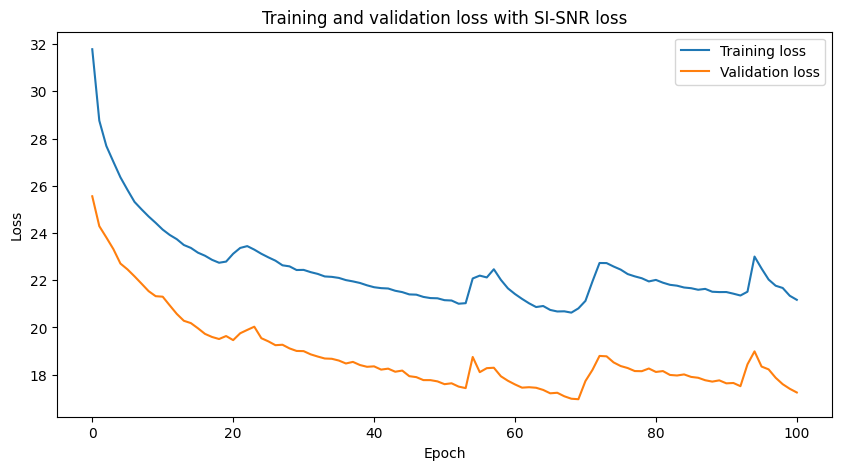

In [129]:
plt.figure(figsize=(10, 5))
plt.plot(t_loss, label='Training loss')
plt.plot(v_loss, label='Validation loss')
plt.title('Training and validation loss with SI-SNR loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

MSE (small model)

In [130]:
# Load back
t_loss = np.load("t_loss_mse_small.npy").tolist()
v_loss = np.load("v_loss_mse_small.npy").tolist()

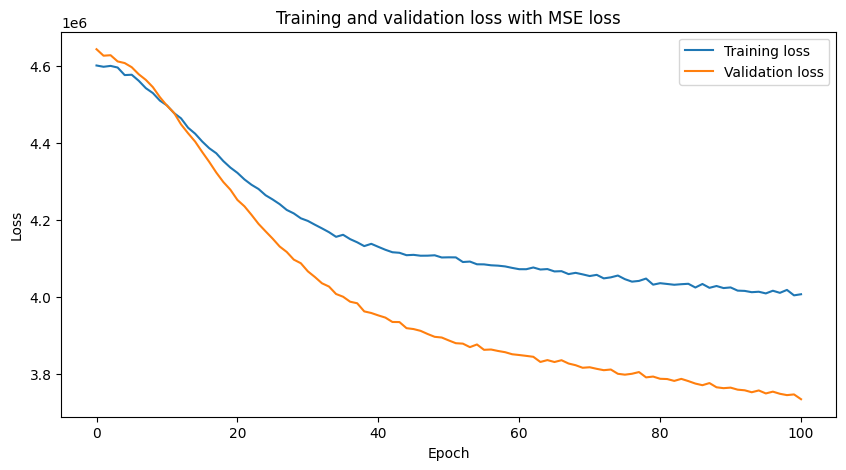

In [131]:
plt.figure(figsize=(10, 5))
plt.plot(t_loss, label='Training loss')
plt.plot(v_loss, label='Validation loss')
plt.title('Training and validation loss with MSE loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

MSE large model

In [132]:
# Load back
t_loss = np.load("t_loss_mse_large.npy").tolist()
v_loss = np.load("v_loss_mse_large.npy").tolist()

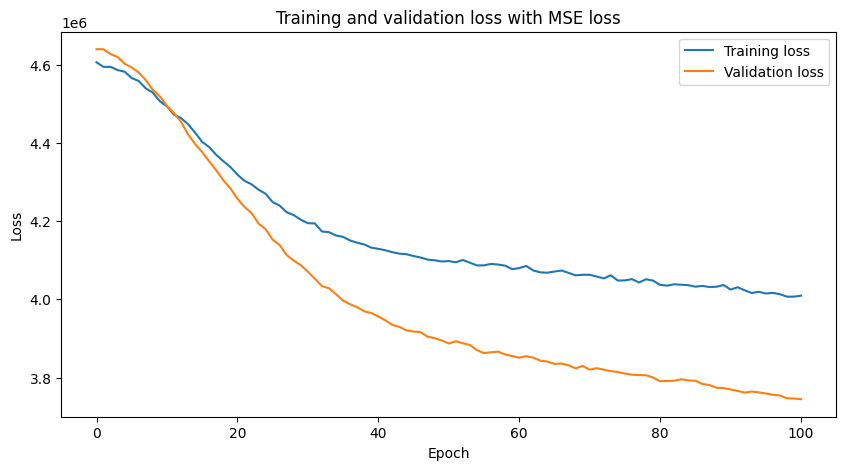

In [133]:
plt.figure(figsize=(10, 5))
plt.plot(t_loss, label='Training loss')
plt.plot(v_loss, label='Validation loss')
plt.title('Training and validation loss with MSE loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Chargement des modèles pour évaluation

In [137]:
model_snr = TasNet(N=N, L=L, H=512, num_layers=1, M=M)

# Step 2: Load the saved weights
model_snr.load_state_dict(torch.load("tasnet_sisnr_epoch_100.pth", map_location=torch.device('cpu')))
num_params = sum(p.numel() for p in model_snr.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")
model_snr

Number of trainable parameters: 2394172


C:\Users\vivie\AppData\Local\Temp\ipykernel_27840\3438077273.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_snr.load_state_dict(torch.load("tasnet_sisnr_epoch_100

TasNet(
  (encoder): TasNetEncoder(
    (conv1d_U): Conv1d(1, 500, kernel_size=(40,), stride=(40,), bias=False)
    (conv1d_V): Conv1d(1, 500, kernel_size=(40,), stride=(40,), bias=False)
  )
  (separator): TasNetSeparator(
    (lstm): LSTM(500, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=500, bias=True)
    (softmax): Softmax(dim=2)
  )
  (decoder): TasNetDecoder()
)

In [138]:
model_small = TasNet(N=N, L=L, H=128, num_layers=1, M=M)

# Step 2: Load the saved weights
model_small.load_state_dict(torch.load("tasnet_mse_small_epoch_100.pth", map_location=torch.device('cpu')))
num_params = sum(p.numel() for p in model_small.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")
model_small

Number of trainable parameters: 448060


C:\Users\vivie\AppData\Local\Temp\ipykernel_27840\240767241.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_small.load_state_dict(torch.load("tasnet_mse_small_epoc

TasNet(
  (encoder): TasNetEncoder(
    (conv1d_U): Conv1d(1, 500, kernel_size=(40,), stride=(40,), bias=False)
    (conv1d_V): Conv1d(1, 500, kernel_size=(40,), stride=(40,), bias=False)
  )
  (separator): TasNetSeparator(
    (lstm): LSTM(500, 128, batch_first=True)
    (fc): Linear(in_features=128, out_features=500, bias=True)
    (softmax): Softmax(dim=2)
  )
  (decoder): TasNetDecoder()
)

In [140]:
model_large = TasNet(N=N, L=L, H=512, num_layers=2, M=M)

# Step 2: Load the saved weights
model_large.load_state_dict(torch.load("tasnet_mse_large_epoch_100.pth", map_location=torch.device('cpu')))
num_params = sum(p.numel() for p in model_large.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")
model_large

Number of trainable parameters: 4495420


C:\Users\vivie\AppData\Local\Temp\ipykernel_27840\1392920074.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_large.load_state_dict(torch.load("tasnet_mse_large_epo

TasNet(
  (encoder): TasNetEncoder(
    (conv1d_U): Conv1d(1, 500, kernel_size=(40,), stride=(40,), bias=False)
    (conv1d_V): Conv1d(1, 500, kernel_size=(40,), stride=(40,), bias=False)
  )
  (separator): TasNetSeparator(
    (lstm): LSTM(500, 512, num_layers=2, batch_first=True)
    (fc): Linear(in_features=512, out_features=500, bias=True)
    (softmax): Softmax(dim=2)
  )
  (decoder): TasNetDecoder()
)

### Résultats visuels

In [156]:
index_to_test = 40

In [157]:
def unit_norm(signal):
    return signal / np.max(signal)

In [178]:
def plot_results(index_to_test):
    dataset = Mydataset('./data/signaux/test/')
    noised, clean = dataset[index_to_test]

    #pass noisy signal through the model
    model_snr.eval()
    model_small.eval()
    model_large.eval()

    with torch.no_grad():
        output_snr = model_snr(noised.unsqueeze(0))
        output_small = model_small(noised.unsqueeze(0))
        output_large = model_large(noised.unsqueeze(0))
        #put numpy
        output_snr = output_snr.squeeze(0).cpu().numpy()[0]
        output_small = output_small.squeeze(0).cpu().numpy()[0]
        output_large = output_large.squeeze(0).cpu().numpy()[0]
    noised = noised.cpu().squeeze(0).numpy()
    clean = clean.squeeze(0).cpu().numpy()

    clean = unit_norm(clean)
    noised = unit_norm(noised)
    output_snr = unit_norm(output_snr)
    output_small = unit_norm(output_small)
    output_large = unit_norm(output_large)

    temps = np.arange(len(noised))/SAMPLERATE
    #figure size
    plt.figure(figsize=(10,5))
    plt.plot(temps, noised, label='Noisy')
    plt.plot(temps, output_snr, label='Output')
    plt.xlabel('Temps (s)')
    plt.title('Noisy signal vs output signal, model snr')
    plt.legend()
    plt.show()

   #figure size
    plt.figure(figsize=(10,5))
    plt.plot(temps, noised, label='Noisy')
    plt.plot(temps, output_small, label='Output')
    plt.xlabel('Temps (s)')
    plt.title('Noisy signal vs output signal, model small')
    plt.legend()
    plt.show()

    #figure size
    plt.figure(figsize=(10,5))
    plt.plot(temps, noised, label='Noisy')
    plt.plot(temps, output_large, label='Output')
    plt.xlabel('Temps (s)')
    plt.title('Noisy signal vs output signal, model large')
    plt.legend()
    plt.show()

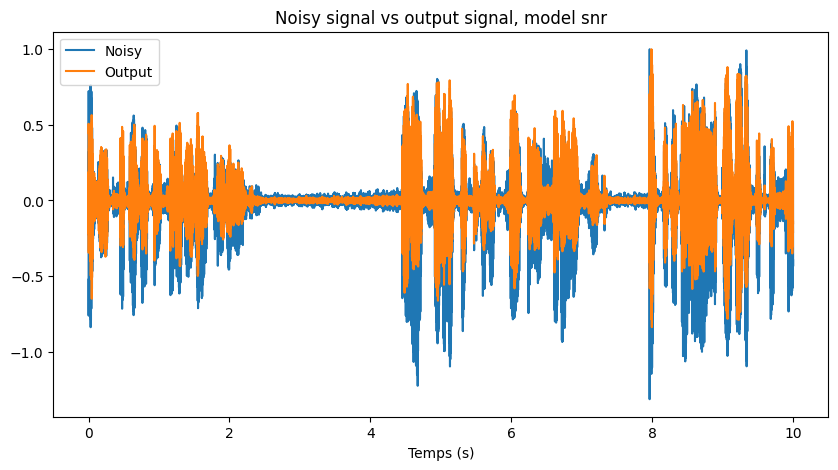

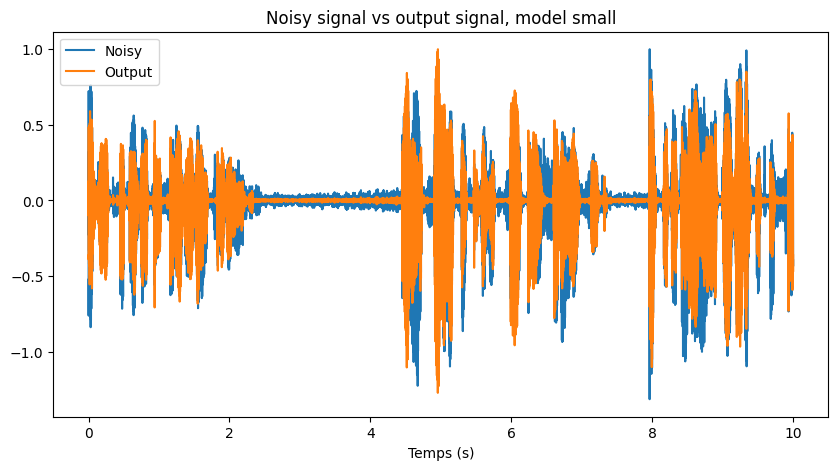

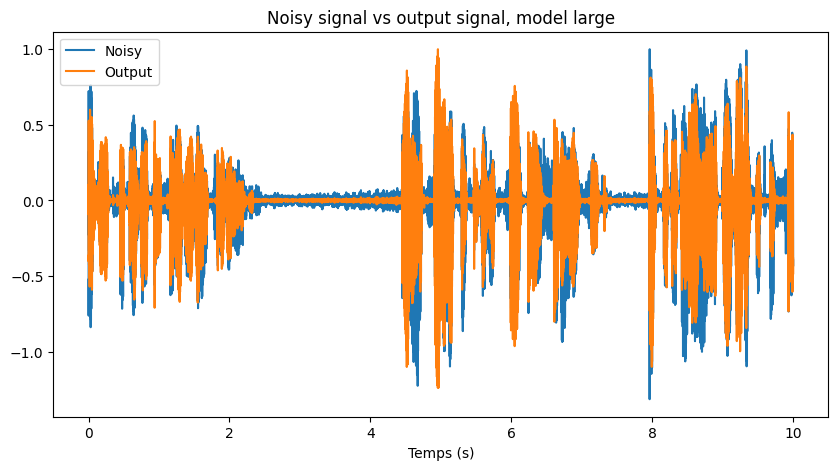

In [179]:
plot_results(index_to_test)

### stoi

In [190]:
def compute_stoi(model, dataloader):
    stoi_values = []
    for noisy_signals, clean_signals in tqdm.tqdm(dataloader_test):
        for i in range(len(noisy_signals)):
            noisy_signal = noisy_signals[i]
            noisy_signal = noisy_signal.cpu()
            model.eval()
            with torch.no_grad():
                output = model(noisy_signal.unsqueeze(0))
                output = output.squeeze(0).cpu().numpy()[0]
            stoi_values.append(stoi(clean_signals[i].squeeze(0).cpu().numpy(), output, SAMPLERATE))
    return np.mean(stoi_values)

In [192]:
stoi_snr = compute_stoi(model_snr, dataloader_test)
print(f"Le stoi moyen pour le modèle snr est de {stoi_snr}")

100%|██████████| 79/79 [04:13<00:00,  3.20s/it]

Le stoi moyen pour le modèle snr est de 0.6707246994800451


In [194]:
stoi_small = compute_stoi(model_small, dataloader_test)
print(f"Le stoi moyen pour le modèle small est de {stoi_small}")

100%|██████████| 79/79 [02:07<00:00,  1.61s/it]

Le stoi moyen pour le modèle small est de 0.5508528044414915


In [193]:
stoi_large = compute_stoi(model_large, dataloader_test)
print(f"Le stoi moyen pour le modèle snr est de {stoi_large}")

100%|██████████| 79/79 [08:02<00:00,  6.11s/it]

Le stoi moyen pour le modèle snr est de 0.5488078131278874


(0.5, 1.0)

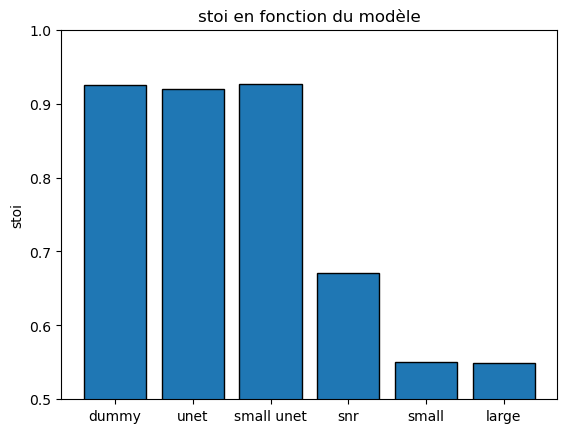

In [53]:

plt.bar(['dummy', 'unet', 'small unet', 'snr', 'small', 'large'], [stoi_dummy, stoi_unet, stoi_small_unet, stoi_snr, stoi_small, stoi_large], edgecolor='black')
plt.ylabel('stoi')
plt.title('stoi en fonction du modèle')
plt.ylim(0.5, 1)

Conclusion:

$\bullet$ Des résultats bien inférieurs à ceux obtenus par le U-Net